In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *

from pyiga import bspline
from pyiga import utils
from pyiga.bspline import BSplineFunc
from pyiga.tensor import apply_tprod
from pyiga import adaptive as adap

import functools

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [19]:
def adaptive(M, nu, j, Ma_T, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    #L2err=np.zeros(maxiter)
    #H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    #params['u_sol']=u_sol
    #params['ux']=ux
    #params['uy']=uy
    MP = assemble.Multipatch(M, automatch = True)
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            MP.mesh.draw(figsize=(6,6), knots=False)
            plt.axis('scaled');
            plt.show()
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[iter] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:0})
        #print(bcs)

        # assemble the linear system
        Kh = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP.assemble_volume('j * v + inner(Ma_T, grad(v)) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in ['M1','M2']],axis=0)

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A))(LS.b))
        #u_ = (cholesky(Mh))(u_rhs)
        #print(check_coupling(MP,u_))
        
        #eh=uh-u_
        #L2err[iter] = sqrt(eh.T@Mh@eh)
        #H1err[iter] = sqrt(eh.T@Kh@eh + L2err[iter]**2)
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if iter < maxiter-1:
            start=time.time()
            err_ind = adap.PoissonEstimator(MP,uh,f=j,a=nu, M=Ma_T, physical=True)
            err_est[iter] = norm(err_ind)
            marked_patches = adap.doerfler_marking(err_ind, theta)
            end = time.time()
            print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            marked_patches = {p:None for p in marked_patches}
            #print(MP.numdofs)
            start = time.time()
            M.split_patches(patches=marked_patches)
            end = time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            
            start=time.time()
            MP = assemble.Multipatch(M, automatch = True)
            end = time.time()
            print("Basis setup took " + str(end-start) + " seconds.")
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return MP, numdofs, err_est

In [20]:
deg = 2
N = deg+1
#kvs=[2 * (bspline.make_knots(deg, 0.0, 1.0, N),),]
kvs = 160*[2 * (bspline.make_knots(deg, 0.0, 1.0, N),),]
a,b,c,d,e,f=.3,1.,1.1,1.15,1.16,1.5
th_m,th_air,th_fe=38.,1.5,4. # 2*th_m + 4*th_air + 2*th_fe = 90
geos=[
    geometry.annulus(r1=a,r2=b,phi=2*pi*th_m/360),                                                 #Fe
    geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*th_m/360),                      #Fe
    geometry.annulus(r1=a,r2=b,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m+th_air)/360),              #Fe
    geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),       #Fe
    geometry.annulus(r1=a,r2=b,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),       #Fe
    geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*2+th_fe)/360),   #Fe
    geometry.annulus(r1=a,r2=b,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe)/360),    #Fe
    geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*2)/360), #Fe
    
    geometry.annulus(r1=b,r2=c,phi=2*pi*th_m/360),                                                 #M1
    geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*th_m/360),                      #Air
    geometry.annulus(r1=b,r2=c,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m+th_air)/360),              #Fe
    geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),       #Air
    geometry.annulus(r1=b,r2=c,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),       #M2
    geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*2+th_fe)/360),   #Air
    geometry.annulus(r1=b,r2=c,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe)/360),    #Fe
    geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*2)/360), #Air
    
    geometry.annulus(r1=c,r2=d,phi=2*pi*th_m/360),                                                 #Fe
    geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*th_m/360),                      #Fe
    geometry.annulus(r1=c,r2=d,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m+th_air)/360),              #Fe
    geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),       #Fe
    geometry.annulus(r1=c,r2=d,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),       #Fe
    geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*2+th_fe)/360),   #Fe
    geometry.annulus(r1=c,r2=d,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe)/360),    #Fe
    geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*2)/360), #Fe
    
    geometry.annulus(r1=d,r2=e,phi=2*pi*th_m/360),                                                 #Air
    geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*th_m/360),                      #Air
    geometry.annulus(r1=d,r2=e,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m+th_air)/360),              #Air
    geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),       #Air
    geometry.annulus(r1=d,r2=e,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),       #Air
    geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*2+th_fe)/360),   #Air
    geometry.annulus(r1=d,r2=e,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe)/360),    #Air
    geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*2)/360), #Air
    
    geometry.annulus(r1=e,r2=f,phi=2*pi*th_m/360),                                                 #Fe
    geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*th_m/360),                      #Fe
    geometry.annulus(r1=e,r2=f,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m+th_air)/360),              #Fe
    geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),       #Fe
    geometry.annulus(r1=e,r2=f,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),       #Fe
    geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*2+th_fe)/360),   #Fe
    geometry.annulus(r1=e,r2=f,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe)/360),    #Fe
    geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*2)/360), #Fe
]

Fe = {0,1,2,3,4,5,6,7,10,14,16,17,18,19,20,21,22,23,32,33,34,35,36,37,38,39}
Fe = set().union(*[{x + 40*i for x in Fe} for i in range(4)])
Air={9,11,13,15,24,25,26,27,28,29,30,31}
Air = set().union(*[{x + 40*i for x in Air} for i in range(4)])
M1={8}
M1 = set().union(*[{x + 40*i for x in M1} for i in range(4)])
M2={12}
M2 = set().union(*[{x + 40*i for x in M2} for i in range(4)])
domains = {'M1':M1,'M2':M2,'Fe':Fe,'Air':Air}

m=-20/360*2*pi
geos = [g.rotate_2d(m) for g in geos] + [g.rotate_2d(pi/2+m) for g in geos] + [g.rotate_2d(pi+m) for g in geos] + [g.rotate_2d(3/2*pi+m) for g in geos]
    
patches = [(k, g) for k, g in zip(kvs,geos)]
patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]
#patches = [(k, g) for k, g in zip(kvs,geos)]

t=time.time()
M = topology.PatchMesh(patches, domains=domains)
print('Detecting interfaces took ' + str(time.time()-t) + ' seconds.')
#M.set_boundary_id({'D1':{(0,2),(8,2),(16,2),(24,2)}})
#M.set_boundary_id({'D2':{(7,3),(15,3),(23,3),(31,3)}})

Detecting interfaces took 11.690397500991821 seconds.


In [17]:
rho=1.28

nu = {'M1': 1e7/(4.344*pi), 'M2':1e7/(4.344*pi), 'Fe':1e5/(204*pi), 'Air': 1e7/(4*pi)}

Ma_T = {'M1': lambda x,y: tuple(rho*nu['M1']*np.array([-y,x])/sqrt(x**2+y**2)), 
        'M2':lambda x,y: tuple(rho*nu['M2']*np.array([y,-x])/sqrt(x**2+y**2)), 
        'Fe':lambda x,y: (0.,0.), 
        'Air': lambda x,y: (0.,0.)}

j = {'M1': lambda x,y: 0.0, 'M2':lambda x,y: 0.0, 'Fe':lambda x,y: 0.0, 'Air': lambda x,y: 0.0}

0


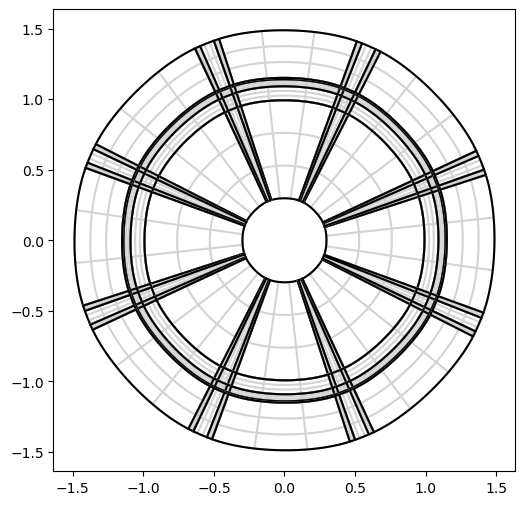

/tmp/ipykernel_3950/561335750.py:38: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh = LS.complete((cholesky(LS.A))(LS.b))


residual contributions took 1.285022497177124 seconds.
jump contributions took 2.358822822570801 seconds.
Estimate and Marking took 3.6444790363311768 seconds.
Refinement took 0.26129150390625 seconds.

1


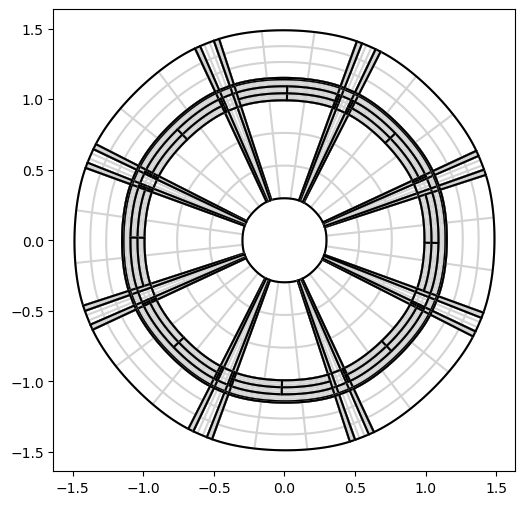

residual contributions took 1.7378933429718018 seconds.
jump contributions took 3.8529255390167236 seconds.
Estimate and Marking took 5.591677904129028 seconds.
Refinement took 0.9584267139434814 seconds.

2


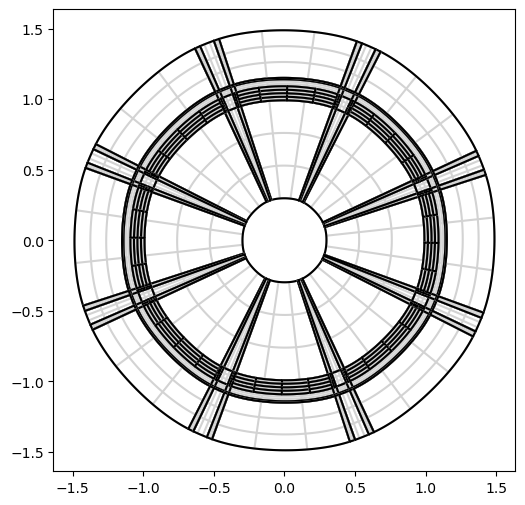

residual contributions took 2.8846707344055176 seconds.
jump contributions took 7.20035195350647 seconds.
Estimate and Marking took 10.086063861846924 seconds.
Refinement took 2.7879936695098877 seconds.

3


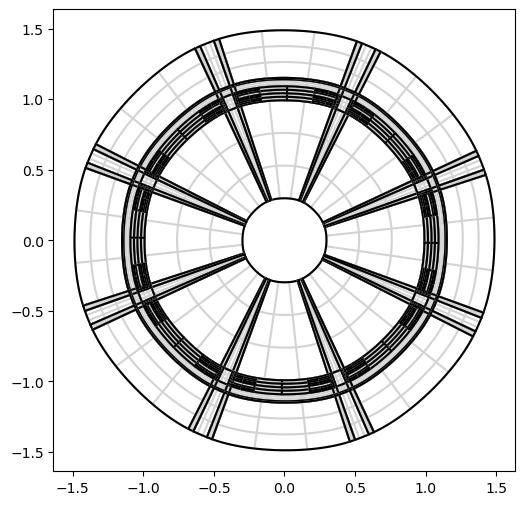

residual contributions took 4.954477310180664 seconds.
jump contributions took 13.292283296585083 seconds.
Estimate and Marking took 18.248544216156006 seconds.
Refinement took 7.59083104133606 seconds.

4


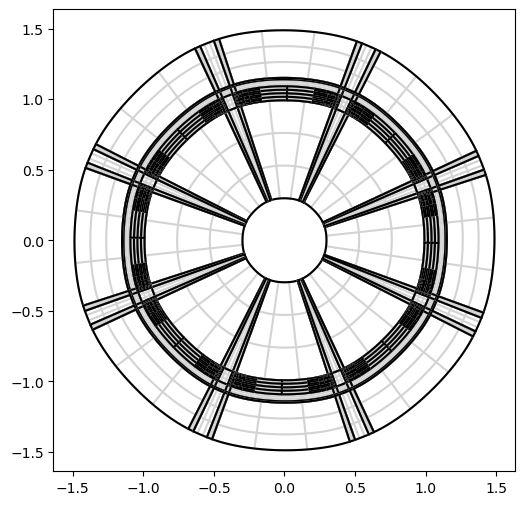

residual contributions took 8.396418571472168 seconds.
jump contributions took 23.03238558769226 seconds.
Estimate and Marking took 31.4316828250885 seconds.
Refinement took 18.584112882614136 seconds.

5


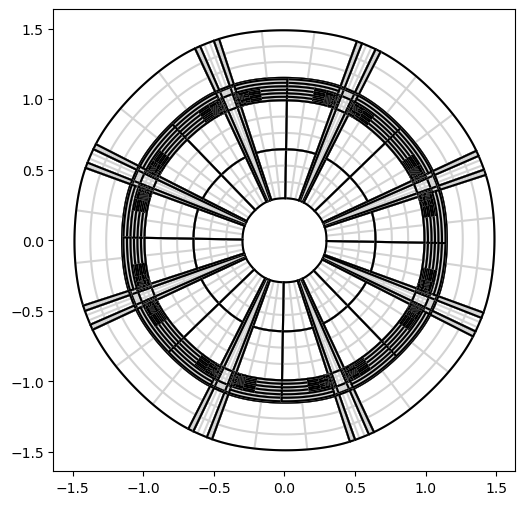

residual contributions took 13.68934965133667 seconds.
jump contributions took 37.283921003341675 seconds.
Estimate and Marking took 50.98045539855957 seconds.
Refinement took 62.45090913772583 seconds.

6


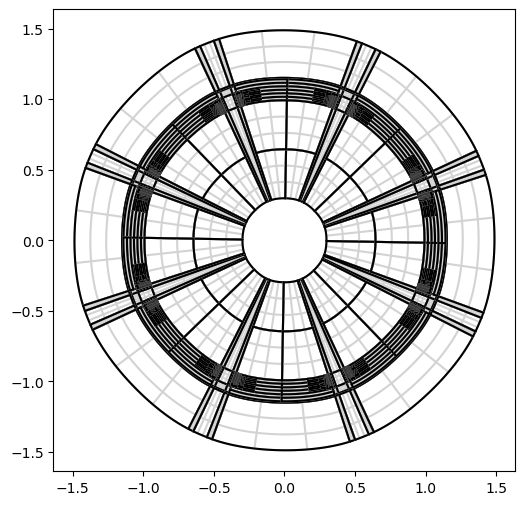

residual contributions took 24.39280128479004 seconds.
jump contributions took 66.26165890693665 seconds.
Estimate and Marking took 90.67486572265625 seconds.
Refinement took 210.7414562702179 seconds.

7


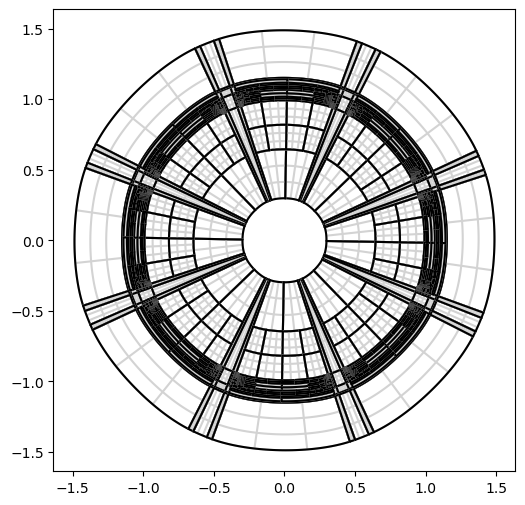

In [18]:
MP, numdofs, err_est = adaptive(M, nu=nu, j=j, Ma_T=Ma_T, theta=0.9, maxiter=8, plotrange=(-1,1), draw=True)

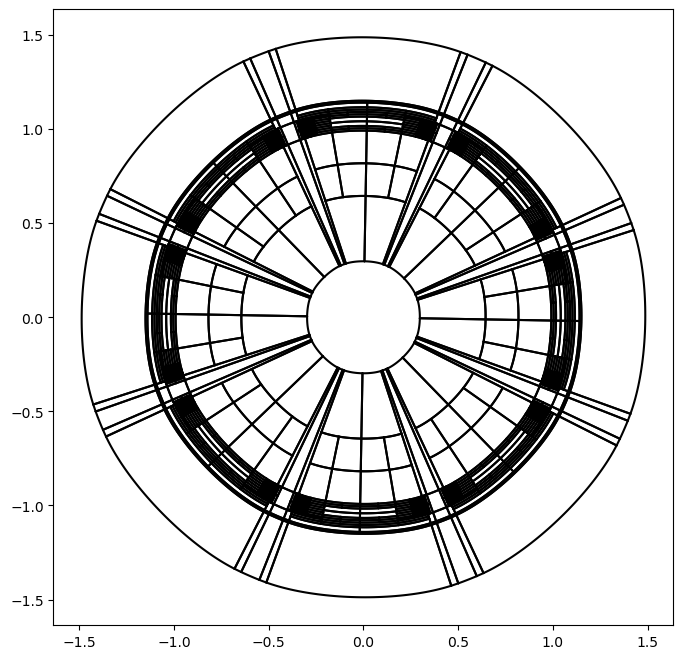

In [22]:
MP.mesh.draw(knots=False)

In [ ]:
numdofs

In [23]:
bcs = MP.compute_dirichlet_bcs({0:lambda x,y: 0.})

Kh = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
F = sum([MP.assemble_volume('j * v + inner(Ma_T, grad(v)) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in ['M1','M2']],axis=0)

LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
#solve system and L2 project exact solution into discrete space
uh=(cholesky(LS.A))(LS.b)
uh = LS.complete(uh)

/tmp/ipykernel_3950/1791736841.py:8: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh=(cholesky(LS.A))(LS.b)


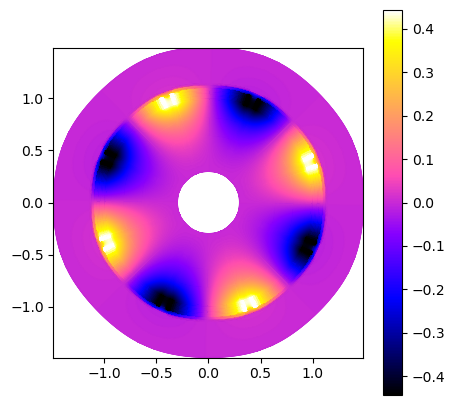

In [24]:
MP.plot(uh,cmap=plt.cm.gnuplot2)

In [26]:
numdofs

array([ 2688.,  3492.,  5604.,  9348., 15796., 25992., 46240., 84948.])

In [7]:
err=adap.PoissonEstimator(MP,uh,f=j,a=nu, M=Ma_T, physical=True)

residual contributions took 1.468482255935669 seconds.
jump contributions took 2.404148817062378 seconds.


In [8]:
marked=adap.doerfler_marking(err,theta=0.8)

In [9]:
marked

[52, 132, 92, 12, 128, 8, 48, 88, 133, 13, 93, 53, 51]

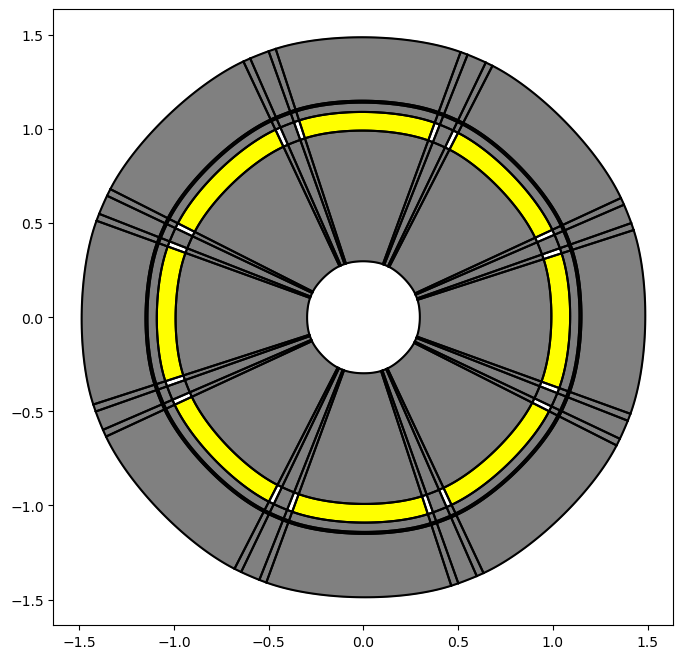

In [20]:
M.draw(knots=False,color={'M1':'yellow', 'M2':'yellow','Fe':'grey','Air':'white'})

In [1]:
M.patch_domains()

NameError: name 'M' is not defined

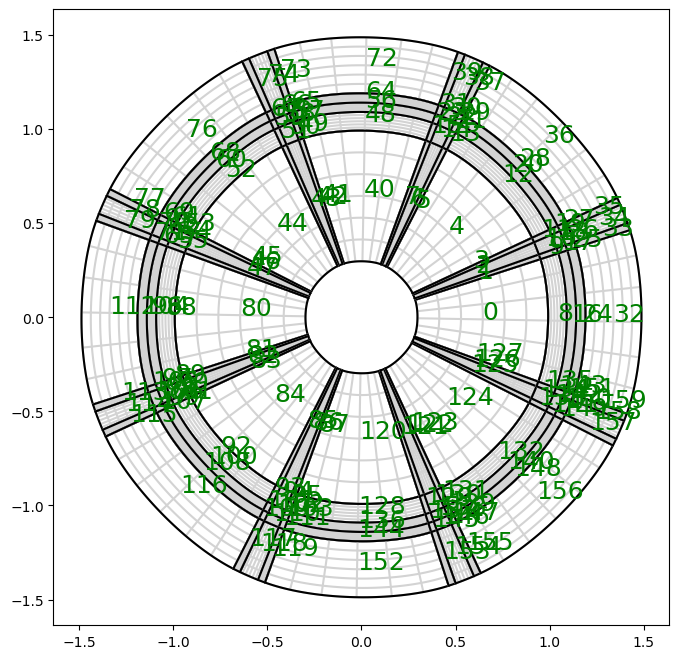

In [8]:
M.draw(patch_idx=True)
axis('scaled');

In [72]:
kvs, geo = M.patches[0][0]

In [73]:
F=assemble.assemble('inner(rho*nu*(-x[1],x[0]), grad(v)) * dx', kvs, arity=1, geo=geo, nu=nu['M1'], rho=1.28).ravel()

In [76]:
F.shape

(121,)

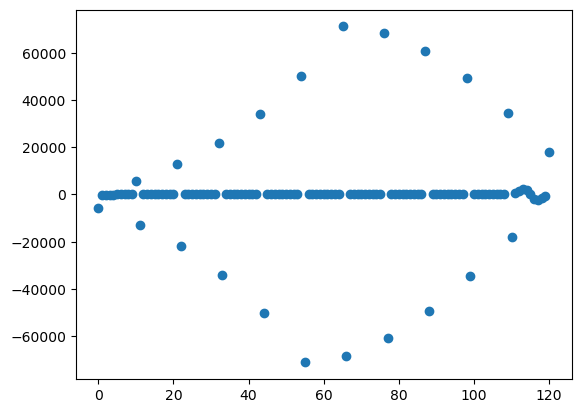

In [40]:
scatter(np.arange(len(F)),F)

In [65]:
vf = vform.VForm(2, arity=1)
v = vf.basisfuns()
M = vf.input('M')
vf.add(f * v * dx)

NameError: name 'dx' is not defined